# Analyzing & Extracting PSP Data Using pySPEDAS
###### Docs: https://pyspedas.readthedocs.io/en/latest/psp.html

In this Jupyter Notebook, I used pySPEDAS to help me visualize and analyze PSP data, in order to choose what data I wanted to export for my website displays. Then I used it to export that data into text files, which I processed into JavaScript lists that I could incorporate directly. The data here is for 2 (eventually will be 3) of the 4 PSP instruments: SWEAP, FIELDS, and eventually ISOIS.

In [2]:
# Change this when updating data to the most recent orbits
STARTORBITS = 13
NUMORBITS = 14

orbit_dates = [
['2018-11-01', '2018-11-11'],
['2019-03-30', '2019-04-10'],
['2019-08-27', '2019-09-07'],
['2020-01-23', '2020-02-04'],
['2020-06-01', '2020-06-13'],
['2020-09-21', '2020-10-02'],
['2021-01-12', '2021-01-23'],
['2021-04-24', '2021-05-04'],
['2021-08-04', '2021-08-15'],
['2021-11-16', '2021-11-26'],
['2022-02-20', '2022-03-02'],
['2022-05-27', '2022-06-07'],
['2022-09-01', '2022-09-11'], 
['2022-12-06', '2022-12-16'], 
['2023-03-12', '2023-03-23']
]

# SWEAP
- This section consists of data for the 3 different components of SWEAP: SPC, SPAN-e, and SPAN-i 
- Data Reference: http://sweap.cfa.harvard.edu/sweap_data_user_guide.pdf

## Solar Probe Cup (SPC)

#### Velocity

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import math
import pyspedas
from pytplot import tplot
spc_vars_tplot = pyspedas.psp.spc(trange=['2021-04-24', '2021-04-30'], datatype='l3i', level='l3', get_support_data=True, notplot=False, no_update=False)
print(spc_vars_tplot)
tplot(['psp_spc_vp_moment_RTN_deltalow', 'psp_spc_vp_moment_RTN_deltahigh', 'psp_spc_vp_fit_RTN_uncertainty'])
tplot(['psp_spc_vp_moment_RTN','psp_spc_vp_fit_RTN'])
tplot(['psp_spc_vp_moment_SC','psp_spc_vp_fit_SC'])

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import math
import pyspedas
from pytplot import tplot
spc_vars_tplot = pyspedas.psp.spc(trange=['2020-01-23', '2020-02-04'], datatype='l3i', level='l3', get_support_data=True, notplot=False, no_update=False)
print(spc_vars_tplot)
tplot(['psp_spc_va_fit_RTN', 'psp_spc_va_fit_RTN_uncertainty'])
tplot(['psp_spc_na_fit','psp_spc_na_fit_uncertainty'])
tplot(['psp_spc_wa_fit', 'psp_spc_wa_fit_uncertainty'])

The first thing I noticed was how there are huge spikes in the vp_fit data compared to vp_moment, which seems like it might be anomalous (my analysis of the wp data below suggests that this could indeed be the case, and so I ended deciding to use moment, not fit, data). The difference between RTN and SC is just the reference frame for the coordinate system, and they give pretty much the same velocities (albeit in slightly different reference frames), so I don't think it matters that much which one I use. In the end, I went with the vp_moment_RTN to process and incorporate into the website.

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import math
import pyspedas
from pytplot import tplot

spc_vars = pyspedas.psp.spc(trange=['2021-04-24', '2021-05-04'], datatype='l3i', level='l3', get_support_data=True, notplot=True, no_update=False)
t1 = spc_vars['psp_spc_vp_moment_RTN']['x']
v1 = spc_vars['psp_spc_vp_moment_RTN']['y']
# t2 = spc_vars['psp_spc_vp_fit_RTN']['x']
# v2 = spc_vars['psp_spc_vp_fit_RTN']['y']
velocities1 = []
for row in v1:
    total = 0
    for dir in row:
        if np.isnan(dir):
            continue
        total += dir**2
    total = math.sqrt(total)
    if total==0:
        total = row[0]
    velocities1.append(total)
fig1, ax1 = plt.subplots(figsize=(12, 4))
ax1.scatter(t1, np.array(velocities1), label="vp_moment", s=1, alpha=0.5)
ax1.set_ylabel("Velocity of protons (km/s)")
ax1.legend()

In [ ]:
spcvelocitydata = pd.DataFrame(np.array(velocities1))
print(f'Percent NaN: {spcvelocitydata.isna().sum().sum() / spcvelocitydata.size * 100:.3f}%')
spcvelocitydata.head()

#### Density

In [ ]:
print(spc_vars)
tplot(['psp_spc_np_moment_deltalow', 'psp_spc_np_moment_deltahigh', 'psp_spc_np_fit_uncertainty'])
tplot(['psp_spc_np_moment','psp_spc_np_fit'])

There doesn't seem to be any huge discrepencies between the np_moment and np_fit data, although the fit data is significantly higher just before April 28. So I'm just going to use np_moment to make it consistent across these data sets.

In [ ]:
densitydata = pd.DataFrame(spc_vars['psp_spc_np_moment']['y'])
print(f'Percent NaN: {densitydata.isna().sum().sum() / densitydata.size * 100:.3f}%')
densitydata.head()

#### Temperature

In [ ]:
tplot(['psp_spc_wp_moment_deltalow', 'psp_spc_wp_moment_deltahigh', 'psp_spc_wp_fit_uncertainty'])
tplot(['psp_spc_wp_moment','psp_spc_wp_fit'])

In a similar fashion to the velocity data, this thermal speed data also had huge spikes in the wp_fit graph (up to 1000 km/s), whereas the wp_moment graph stayed relatively consistent within 20-200 km/s. So I used T = (mv^2)/2k to calculate example temperatures: 150 km/s turned out to be around 1.36 million Kelvin, which is reasonably accurate to the actual temperature of the corona (and the PSP is indeed inside the corona at this time), but 1000 km/s was a whopping 60.57 million Kelvin, which I think is likely some sort of error as that is way hotter than even the sun's core (15 million Kelvin). As a result, I decided that it'd be better to use the moment data across the board (instead of fit), also taking into consideration this important note from the SWEAP user guide.

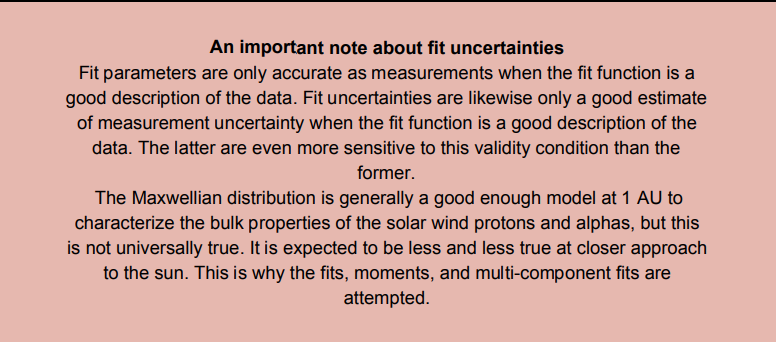

Now, of course, since I am only using this data in order to visualize it and help people understand it better (not for any scientific purpose), accuracy of measurement is not necessarily a requirement, but I have still tried to pick the data set (between moment & fit) that best represents what SWEAP is trying to measure.

In [ ]:
thermaldata = pd.DataFrame(spc_vars['psp_spc_wp_moment']['y'])
print(f'Percent NaN: {thermaldata.isna().sum().sum() / thermaldata.size * 100:.3f}%')
thermaldata.head()

### SPAN-e (electrons)

#### spa_sf1_32e
- this l2 datatype only represents the SPAN-A electron data (spb_sf1_32e contains SPAN-B data)

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import math
import pyspedas
from pytplot import tplot
import pandas as pd

spe_vars_tplot = pyspedas.psp.spe(trange=['2021-04-24', '2021-05-04'], datatype='spa_sf1_32e', level='l2', notplot=False, time_clip=False)
print(spe_vars_tplot)
tplot('psp_spe_EFLUX')

#### spe_sf0_pad
- This l3 datatype represents the data of SPAN-A and SPAN-B combined
- This is what I exported and used in the website

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import math
import pyspedas
from pytplot import tplot
import pandas as pd

spe_vars_tplot = pyspedas.psp.spe(trange=['2021-04-24', '2021-05-04'], datatype='spe_sf0_pad', level='l3', notplot=False, time_clip=False)
print(spe_vars_tplot)
tplot('psp_spe_EFLUX_VS_PHI')
tplot('psp_spe_EFLUX_VS_ENERGY')

In [ ]:
spe_vars = pyspedas.psp.spe(trange=['2021-04-24', '2021-05-04'], datatype='spe_sf0_pad', level='l3', notplot=True, time_clip=False)

In [ ]:
efluxdata = pd.DataFrame(spe_vars['psp_spe_EFLUX_VS_ENERGY']['y'])
print(f'Percent NaN: {efluxdata.isna().sum().sum() / efluxdata.size * 100:.3f}%')
efluxdata.shape

In [ ]:
# Estimations of the average energies (eV) for the 32 different electron energy bins obtained from the graph above
energy_bins = [2,2.6,3.3,4.2,5.1,6.1,7.9,9.9,12.5,15,19,24,29,36,45,56,70,88,112,133,175,212,257,333,400,490,600,780,950,1200,1500,1800]

totalelectrons = []
for row in spe_vars['psp_spe_EFLUX']['y']:
    total = 0
    for i in range(32):
        total += row[i] / energy_bins[i]
    totalelectrons.append(total)
plt.plot(spe_vars['psp_spe_EFLUX']['x'], np.array(totalelectrons), label='Total Electrons')
plt.legend()

### SPAN-i (ions)

In [ ]:
spi_vars_tplot = pyspedas.psp.spi(trange=['2021-04-24', '2021-04-30'], datatype='spi_sf0a_mom_inst', level='l3', time_clip=False)
print(spi_vars_tplot)
tplot(['psp_spi_TEMP'])
tplot(['psp_spi_DENS', 'psp_spi_VEL'])
tplot(['psp_spi_EFLUX_VS_ENERGY'])
#tplot(['psp_spi_MAGF_SC', 'psp_spi_MAGF_INST'])

In [ ]:
spi_vars = pyspedas.psp.spi(trange=['2021-04-24', '2021-04-30'], datatype='spi_sf0a_mom_inst', level='l3', notplot=True, time_clip=False)

In [ ]:
spifluxdata = pd.DataFrame(spi_vars['psp_spi_EFLUX_VS_ENERGY']['y'])
spifluxdata.shape

In [ ]:
spitempdata = pd.DataFrame(spi_vars['psp_spi_TEMP']['y'])
print(f'Percent NaN: {spitempdata.isna().sum().sum() / spitempdata.size * 100:.3f}%')
spitempdata.head()

### Spacecraft Position

In [ ]:
pos = spc_vars['psp_spc_sc_pos_HCI']['y']
spc_vars['psp_spc_sc_pos_HCI']['y'][:,0]
plt.plot(-spc_vars['psp_spc_sc_pos_HCI']['y'][:,0], spc_vars['psp_spc_sc_pos_HCI']['y'][:,1])
dist = []
for row in pos:
    dist.append(math.sqrt(row[0]**2 + row[1]**2 + row[2]**2) / 149597870.7)

In [ ]:
spc_vars['psp_spc_sc_pos_HCI']['y'][:,0]

### Spacecraft Velocity

In [ ]:
plt.plot(spc_vars['psp_spc_sc_vel_HCI']['x'], spc_vars['psp_spc_sc_vel_HCI']['y'])
velocityvectors = spc_vars['psp_spc_sc_vel_HCI']['y']
pspvelocity = []
for row in velocityvectors:
    pspvelocity.append(math.sqrt(row[0]**2 + row[1]**2 + row[2]**2))
plt.plot(spc_vars['psp_spc_sc_vel_HCI']['x'], np.array(pspvelocity), label="Total Velocity")
plt.legend()

## SPC Data Processing

In [ ]:
# Checking the percent NaN values
from datetime import datetime
import numpy as np
from matplotlib import pyplot as plt
import math
import pyspedas
from pytplot import tplot
import pandas as pd

m = 1.67262192 * 10**(-27) # Mass of a proton (kg)
k = 1.380649 * 10**(-23) # Boltzmann constant (J/K)
for orbit in range(STARTORBITS, NUMORBITS+1):
    print(f"- - ORBIT {orbit} - -")
    spc_vars = pyspedas.psp.spc(trange=orbit_dates[orbit-1], datatype='l3i', level='l3', get_support_data=True, notplot=True, no_update=False)
    # Velocity
    t1 = spc_vars['psp_spc_vp_moment_RTN']['x']
    v1 = spc_vars['psp_spc_vp_moment_RTN']['y']
    velocities1 = []
    for row in v1:
        total = 0
        for dir in row:
            if np.isnan(dir):
                continue
            total += dir**2
        total = math.sqrt(total)
        if total==0:
            total = row[0]
        velocities1.append(total)
    velodata = pd.DataFrame(np.array(velocities1))
    print(f'Velocity % NaN: {velodata.isna().sum().sum() / velodata.size * 100:.3f}%')
    # Density
    densitydata = pd.DataFrame(spc_vars['psp_spc_np_moment']['y'])
    print(f'Density % NaN: {densitydata.isna().sum().sum() / densitydata.size * 100:.3f}%')
    # Temperature
    thermaldata = pd.DataFrame(spc_vars['psp_spc_wp_moment']['y'])
    print(f'Temperature % NaN: {thermaldata.isna().sum().sum() / thermaldata.size * 100:.3f}%')
    # Spacecraft Velocity
    velocityvectors = spc_vars['psp_spc_sc_vel_HCI']['y']
    pspvelocity = []
    for row in velocityvectors:
        pspvelocity.append(math.sqrt(row[0]**2 + row[1]**2 + row[2]**2))
    pspvelodata = pd.DataFrame(np.array(pspvelocity))
    print(f'PSP Velocity % NaN: {pspvelodata.isna().sum().sum() / pspvelodata.size * 100:.3f}%')

In [ ]:
# Processing data and exporting text files
from datetime import datetime
import numpy as np
from matplotlib import pyplot as plt
import math
import pyspedas
from pytplot import tplot
import pandas as pd

m = 1.67262192 * 10**(-27) # Mass of a proton (kg)
k = 1.380649 * 10**(-23) # Boltzmann constant (J/K)
for orbit in range(STARTORBITS, NUMORBITS+1):
    spc_vars = pyspedas.psp.spc(trange=orbit_dates[orbit-1], datatype='l3i', level='l3', get_support_data=True, notplot=True, no_update=False)
    # Velocity
    t1 = spc_vars['psp_spc_vp_moment_RTN']['x']
    v1 = spc_vars['psp_spc_vp_moment_RTN']['y']
    velocities1 = []
    for row in v1:
        total = 0
        for dir in row:
            if np.isnan(dir):
                continue
            total += dir**2
        total = math.sqrt(total)
        if total==0:
            total = row[0]
        velocities1.append(total)
    # Position
    pos = spc_vars['psp_spc_sc_pos_HCI']['y']
    dist = []
    for row in pos:
        dist.append(math.sqrt(row[0]**2 + row[1]**2 + row[2]**2) / 149597870.7)
    # Spacecraft Velocity
    velocityvectors = spc_vars['psp_spc_sc_vel_HCI']['y']
    pspvelocity = []
    for row in velocityvectors:
        pspvelocity.append(math.sqrt(row[0]**2 + row[1]**2 + row[2]**2))
    with open(f"sweap_data/sweap_txt_data/spc_orbit{orbit}.txt", 'w') as output:
        for i in range(1, t1.shape[0]):
            outstring = ""
            n = i
            if t1[i].minute != t1[i-1].minute : #if t1[i].minute - t1[i-1].minute != 1 and t1[i].minute != 0:
                # Date
                outstring += t1[i].strftime('%Y%m%d_%H%M') + ", "
                # Velocity (km/s)
                while np.isnan(velocities1[n]):
                    n += 1
                outstring += f"{velocities1[n]}, "
                n = i
                # Density (1/cm^2)
                while np.isnan(spc_vars['psp_spc_np_moment']['y'][n]):
                    n += 1
                outstring += f"{spc_vars['psp_spc_np_moment']['y'][n]}, "
                n = i
                # Temperature (K)
                while np.isnan(spc_vars['psp_spc_wp_moment']['y'][n]):
                    n += 1
                tv = spc_vars['psp_spc_wp_moment']['y'][n]
                outstring += f"{(m*(tv*1000)**2 / (2*k))}, "
                n = i
                # X-coordinate (km)
                outstring += f"{spc_vars['psp_spc_sc_pos_HCI']['y'][n][0]}, "
                # Y-coordinate (km)
                outstring += f"{spc_vars['psp_spc_sc_pos_HCI']['y'][n][1]}, "
                # Distance (km)
                outstring += f"{dist[i]}, "
                # Spacecraft Velocity (km/s)
                outstring += f"{pspvelocity[n]}"
                output.write(outstring + "\n")

In [ ]:
# Creating the location plots for the position display

for highlight in range(NUMORBITS):
    plt.figure(figsize=(10, 10), dpi=200)
    plt.xlim([-4.4e7, 4e7])
    plt.ylim([-4.7e7, 3.7e7])
    for ORB in range(NUMORBITS):
        # Loads orbit data
        spc_vars = pyspedas.psp.spc(trange=orbit_dates[ORB], datatype='l3i', level='l3', varnames = ['sc_pos_HCI'], notplot=True, no_update=False)
        plt.scatter(spc_vars['psp_spc_sc_pos_HCI']['y'][:,0], spc_vars['psp_spc_sc_pos_HCI']['y'][:,1], s=2, c = '#7d3d00')
    # Graphs highlighted orbit on top
    spc_vars = pyspedas.psp.spc(trange=orbit_dates[highlight], datatype='l3i', level='l3', varnames = ['sc_pos_HCI'], notplot=True, no_update=False)
    plt.scatter(spc_vars['psp_spc_sc_pos_HCI']['y'][:,0], spc_vars['psp_spc_sc_pos_HCI']['y'][:,1], s=8, c = '#ff7b00')
    plt.scatter(np.array([0]), np.array([0]), s=5, c = '#ff7b00')
    plt.savefig(f'public/orbit_plot2_{highlight+1}.png', transparent = True)

## SPAN-e Data Processing

In [ ]:
# Processing SWEAP-e data and exporting text files
from datetime import datetime
import numpy as np
from matplotlib import pyplot as plt
import math
import pyspedas
from pytplot import tplot
import pandas as pd

# Estimations of the average energies (eV) for the 32 different electron energy bins obtained from the graph above
energy_bins = [2,2.6,3.3,4.2,5.1,6.1,7.9,9.9,12.5,15,19,24,29,36,45,56,70,88,112,133,175,212,257,333,400,490,600,780,950,1200,1500,1800]

for orbit in range(STARTORBITS, NUMORBITS+1):
    spe_vars = pyspedas.psp.spe(trange=orbit_dates[orbit-1], datatype='spe_sf0_pad', level='l3', notplot=True, time_clip=False)
    t2 = spe_vars['psp_spe_EFLUX_VS_ENERGY']['x']
    with open(f"sweap_data/sweap_txt_data/spane_orbit{orbit}.txt", 'w') as output:
        for i in range(1, t2.shape[0]):
            outstring = ""
            n = i
            if t2[i].minute != t2[i-1].minute : #if t1[i].minute - t1[i-1].minute != 1 and t1[i].minute != 0:
                # Date
                outstring += t2[i].strftime('%Y%m%d_%H%M') + ", "
                # Electron Energies 
                for j in range(32):
                    energyval = spe_vars['psp_spe_EFLUX_VS_ENERGY']['y'][i][j]
                    outstring += f"{energyval:.1f}"
                    if j != 32:
                        outstring += f", "
                output.write(outstring + "\n")

In [ ]:
# Estimations of the average energies (eV) for the 32 different electron energy bins obtained from the graph above
energy_bins = [2,2.6,3.3,4.2,5.1,6.1,7.9,9.9,12.5,15,19,24,29,36,45,56,70,88,112,133,175,212,257,333,400,490,600,780,950,1200,1500,1800]

totalelectrons = []
for row in spe_vars['psp_spe_EFLUX']['y']:
    total = 0
    for i in range(32):
        total += row[i] / energy_bins[i]
    totalelectrons.append(total)
plt.plot(spe_vars['psp_spe_EFLUX']['x'], np.array(totalelectrons), label='Total Electrons')
plt.legend()

In [ ]:
efluxdata = pd.DataFrame(spe_vars['psp_spe_EFLUX']['y'])
print(f'Percent NaN: {efluxdata.isna().sum().sum() / efluxdata.size * 100:.3f}%')

## SPAN-i Data Processing

In [ ]:
# Visualizing and analyzing SPAN-i data with pyspedas
import numpy as np
from matplotlib import pyplot as plt
import math
import pyspedas
from pytplot import tplot
spani_vars_tplot = pyspedas.psp.spi(trange=orbit_dates[13], datatype='spi_sf0a_mom_inst', level='l3', notplot=False, time_clip=False) # 'spi_sf0a_l3_mom'
print(spani_vars_tplot)
tplot(['psp_spi_VEL'])
tplot(['psp_spi_DENS'])
tplot(['psp_spi_TEMP'])

In [ ]:
# Processing data and exporting text files (data only available for orbits 2-8)
from datetime import datetime
import numpy as np
from matplotlib import pyplot as plt
import math
import pyspedas
from pytplot import tplot
import pandas as pd

for orbit in range(2,NUMORBITS+1):
    print(f"orbit {orbit}")
    if orbit <= 8 and orbit >= 2:
        spi_vars = pyspedas.psp.spi(trange=orbit_dates[orbit-1], datatype='spi_sf0a_mom_inst', level='l3', notplot=True, time_clip=False)
        velocity_type = 'psp_spi_VEL'
    else:
        spi_vars = pyspedas.psp.spi(trange=orbit_dates[orbit-1], datatype='spi_sf0a_l3_mom', level='l3', notplot=True, time_clip=False)
        velocity_type = 'psp_spi_VEL_INST'
    # Velocity
    t1 = spi_vars[velocity_type]['x']
    v1 = spi_vars[velocity_type]['y']
    velocities2 = []
    for row in v1:
        total = 0
        for dir in row:
            if np.isnan(dir):
                continue
            total += dir**2
        total = math.sqrt(total)
        if total==0:
            total = row[0]
        velocities2.append(total)
    with open(f"sweap_data/sweap_txt_data/spani_orbit{orbit}.txt", 'w') as output:
        for i in range(1, t1.shape[0]):
            outstring = ""
            n = i
            if t1[i].minute != t1[i-1].minute : #if t1[i].minute - t1[i-1].minute != 1 and t1[i].minute != 0:
                # Date
                outstring += t1[i].strftime('%Y%m%d_%H%M') + ", "
                # Velocity (km/s)
                while np.isnan(velocities2[n]) and n < len(velocities2)-1:
                    n += 1
                outstring += f"{velocities2[n]:.5f}, "
                n = i
                # Density (1/cm^3)
                while (np.isnan(spi_vars['psp_spi_DENS']['y'][n]) or spi_vars['psp_spi_DENS']['y'][n] < 0.01) and n < len(velocities2)-1:
                    n += 1
                outstring += f"{spi_vars['psp_spi_DENS']['y'][n]}, "
                n = i
                # Temperature (K)
                while np.isnan(spi_vars['psp_spi_TEMP']['y'][n]) and n < len(velocities2)-1:
                    n += 1
                tv = spi_vars['psp_spi_TEMP']['y'][n]
                outstring += f"{tv * 11604.51812:.3f}" # converting from eV to Kelvin
                n = i
                output.write(outstring + "\n")

In [ ]:
print("['psp_spi_QUALITY_FLAG', 'psp_spi_DENS', 'psp_spi_VEL', 'psp_spi_T_TENSOR', 'psp_spi_TEMP', 'psp_spi_EFLUX_VS_ENERGY', 'psp_spi_EFLUX_VS_THETA', 'psp_spi_EFLUX_VS_PHI', 'psp_spi_MAGF_SC', 'psp_spi_MAGF_INST']")

# FIELDS
- https://fields.ssl.berkeley.edu/data/

Valid options (taken from pySPEDAS docs):
‘mag_RTN’, ‘mag_RTN_1min’, ‘mag_rtn_4_per_cycle’, (SPDF only) ‘mag_RTN_4_Sa_per_Cyc’ ‘mag_SC’ ‘mag_SC_1min’ ‘mag_sc_4_per_cycle’ (SPDF only) ‘mag_SC_4_Sa_per_Cyc’ ‘mag_VSO’ (limited dates) ‘rfs_burst’ (limited dates) ‘rfs_hfr’, ‘rfs_lfr’ ‘f2_100bps’ ‘dfb_dc_spec’ ‘dfb_ac_spec’ ‘dfb_dc_xspec’ ‘dfb_ac_xspec’ ‘merged_scam_wf’ ‘sqtn_rfs_V1V2’

### Data Pre-Visualization

In [ ]:
import pyspedas
from pytplot import tplot

fields_vars_tplot = pyspedas.psp.fields(trange=['2018-11-5', '2018-11-6'], datatype='mag_rtn', level='l2', time_clip=False)
tplot('psp_fld_l2_mag_RTN')

In [ ]:
import pyspedas
from pytplot import tplot

fields_vars_tplot = pyspedas.psp.fields(trange=['2020-06-12', '2020-06-13'], datatype='sqtn_rfs_v1v2', level='l3', time_clip=False)
print(fields_vars_tplot)
tplot('electron_density')
tplot('electron_core_temperature')
tplot('electron_density_delta')

In [ ]:
import pyspedas
from pytplot import tplot

fields_vars_tplot = pyspedas.psp.fields(trange=['2020-06-12', '2020-06-13'], datatype='dfb_dc_spec_dV12hg', level='l2', time_clip=False)
print(fields_vars_tplot)
tplot('psp_fld_l2_dfb_dc_spec_dV12hg')

In [ ]:
import pyspedas
from pytplot import tplot

fields_vars_tplot = pyspedas.psp.fields(trange=['2020-06-12', '2020-06-13'], datatype='dfb_ac_spec', level='l2', time_clip=False)
print(fields_vars_tplot)
for var in ['psp_fld_l2_dfb_ac_spec_dV12hg', 'psp_fld_l2_dfb_ac_spec_dV34hg', 'psp_fld_l2_dfb_ac_spec_V5hg']:
    tplot(var)

### Data Analyzing

##### mag_rtn

In [ ]:
import pyspedas
from pytplot import tplot
mag_var = pyspedas.psp.fields(trange=['2018-11-5', '2018-11-6'], datatype='mag_rtn', level='l2', notplot=True, time_clip=False)
print(mag_var)

In [ ]:
import pandas as pd
magdata = pd.DataFrame(mag_var['psp_fld_l2_mag_RTN']['y'])
print(f'Percent NaN: {magdata.isna().sum().sum() / magdata.size * 100:.3f}%')
magdata.head()

##### dfb_dc_spec_dV12hg

In [ ]:
import pyspedas
from pytplot import tplot
dc_var = pyspedas.psp.fields(trange=['2020-06-12', '2020-06-13'], datatype='dfb_dc_spec_dV12hg', level='l2', notplot=True, time_clip=False)
print(dc_var)

In [ ]:
import pandas as pd
dcdata = pd.DataFrame(dc_var['psp_fld_l2_dfb_dc_spec_dV12hg']['y'])
print(f'Percent NaN: {dcdata.isna().sum().sum() / dcdata.size * 100:.3f}%')
dcdata.head()

##### dfb_ac_spec_dV12hg

In [ ]:
import pyspedas
from pytplot import tplot
ac_var = pyspedas.psp.fields(trange=['2020-06-12', '2020-06-13'], datatype='dfb_ac_spec_dV12hg', level='l2', notplot=True, time_clip=False)
print(ac_var)

In [ ]:
import pandas as pd
acdata = pd.DataFrame(ac_var['psp_fld_l2_dfb_ac_spec_dV12hg']['y'])
print(f'Percent NaN: {acdata.isna().sum().sum() / acdata.size * 100:.3f}%')
acdata.head()

### FIELDS Data Processing

In [ ]:
# Processing FIELDS data and exporting text files
from datetime import datetime, timedelta
import numpy as np
from matplotlib import pyplot as plt
import math
import pyspedas
from pytplot import tplot
import pandas as pd

orbit_dates = [
['18-11-01', '18-11-11'],
['19-03-30', '19-04-10'],
['19-08-27', '19-09-07'],
['20-01-23', '20-02-04'],
['20-06-01', '20-06-13'],
['20-09-21', '20-10-02'],
['21-01-12', '21-01-23'],
['21-04-24', '21-05-04'],
['21-08-04', '21-08-15'],
['21-11-16', '21-11-26'],
['22-02-20', '22-03-02'],
['22-05-27', '22-06-07'],
['22-09-01', '22-09-11'], 
['22-12-06', '22-12-16'], 
['23-03-12', '23-03-23']
]

for orbit in range(STARTORBITS, NUMORBITS+1):
    start = datetime.strptime(orbit_dates[orbit-1][0], '%y-%m-%d')
    end = datetime.strptime(orbit_dates[orbit-1][1], '%y-%m-%d')
    ndays = (end - start).days
    for day in range(ndays):
        mag_var = pyspedas.psp.fields(trange=[start.strftime('%Y-%m-%d'), (start+timedelta(days=1)).strftime('%Y-%m-%d')], datatype='mag_rtn', level='l2', notplot=True, time_clip=False)
        dc_var = pyspedas.psp.fields(trange=[start.strftime('%Y-%m-%d'), (start+timedelta(days=1)).strftime('%Y-%m-%d')], datatype='dfb_dc_spec_dV12hg', level='l2', notplot=True, time_clip=False)
        ac_var = pyspedas.psp.fields(trange=[start.strftime('%Y-%m-%d'), (start+timedelta(days=1)).strftime('%Y-%m-%d')], datatype='dfb_ac_spec_dV12hg', level='l2', notplot=True, time_clip=False)
        print([start.strftime('%Y-%m-%d'), (start+timedelta(days=1)).strftime('%Y-%m-%d')])
        t = dc_var['psp_fld_l2_dfb_dc_spec_dV12hg']['x']
        with open(f"fields_data/fields_txt_data/fields_orbit{orbit}.txt", 'a') as output:
            for i in range(1, t.shape[0]):
                outstring = ""
                n = i
                if t[i].minute != t[i-1].minute : #if t1[i].minute - t1[i-1].minute != 1 and t1[i].minute != 0:
                    # Date
                    outstring += t[i].strftime('%Y%m%d_%H%M') + ", "
                    # Magnetic Field
                    for j in range(3):
                        magval = mag_var['psp_fld_l2_mag_RTN']['y'][i][j]
                        outstring += f"{magval:.1f}, "
                    # DC Spectra
                    for j in range(54):
                        outstring += f"{dc_var['psp_fld_l2_dfb_dc_spec_dV12hg']['y'][i][j]*10**12:.2f}, "
                    # AC Spectra
                    for j in range(53):
                        outstring += f"{ac_var['psp_fld_l2_dfb_ac_spec_dV12hg']['y'][i][j]*10**12:.2f}, "
                    outstring += f"{ac_var['psp_fld_l2_dfb_ac_spec_dV12hg']['y'][i][53]*10**12:.2f}"
                    output.write(outstring + "\n")
        start += timedelta(days=1)

# ISOIS
- https://spdf.gsfc.nasa.gov/pub/data/psp/isois/
- https://spp-isois.sr.unh.edu/data_public/ISOIS_Data_Glossary.pdf

### Data Pre-Visualization

In [41]:
import pyspedas
from pytplot import tplot
epi_vars = pyspedas.psp.epihi(trange=orbit_dates[1], datatype='let1_rates1h', level='l2', time_clip=False)
print(epi_vars)

06-Aug-23 22:18:44: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/psp/isois/epihi/l2/let1_rates1h/2019/
06-Aug-23 22:18:44: File is current: psp_data/isois/epihi/l2/let1_rates1h/2019/psp_isois-epihi_l2-let1-rates3600_20190330_v16.cdf
06-Aug-23 22:18:44: File is current: psp_data/isois/epihi/l2/let1_rates1h/2019/psp_isois-epihi_l2-let1-rates3600_20190331_v16.cdf
06-Aug-23 22:18:45: File is current: psp_data/isois/epihi/l2/let1_rates1h/2019/psp_isois-epihi_l2-let1-rates3600_20190401_v16.cdf
06-Aug-23 22:18:45: File is current: psp_data/isois/epihi/l2/let1_rates1h/2019/psp_isois-epihi_l2-let1-rates3600_20190402_v16.cdf
06-Aug-23 22:18:45: File is current: psp_data/isois/epihi/l2/let1_rates1h/2019/psp_isois-epihi_l2-let1-rates3600_20190403_v16.cdf
06-Aug-23 22:18:45: File is current: psp_data/isois/epihi/l2/let1_rates1h/2019/psp_isois-epihi_l2-let1-rates3600_20190404_v16.cdf
06-Aug-23 22:18:45: File is current: psp_data/isois/epihi/l2/let1_rates1h/2019/psp_isois-epihi_l2-le

['psp_epihi_R1A_He_BIN', 'psp_epihi_R1A_Ne_BIN', 'psp_epihi_R1B_He_BIN', 'psp_epihi_R1B_Ne_BIN', 'psp_epihi_R2A_He_BIN', 'psp_epihi_R2A_Ne_BIN', 'psp_epihi_R2B_He_BIN', 'psp_epihi_R2B_Ne_BIN', 'psp_epihi_R3A_He_BIN', 'psp_epihi_R3A_Ne_BIN', 'psp_epihi_R3B_He_BIN', 'psp_epihi_R3B_Ne_BIN', 'psp_epihi_R45A_He_BIN', 'psp_epihi_R45A_Ne_BIN', 'psp_epihi_R45B_He_BIN', 'psp_epihi_R45B_Ne_BIN', 'psp_epihi_R6A_He_BIN', 'psp_epihi_R6A_Ne_BIN', 'psp_epihi_R6B_He_BIN', 'psp_epihi_R6B_Ne_BIN', 'psp_epihi_A_Al', 'psp_epihi_A_Ar', 'psp_epihi_A_C', 'psp_epihi_A_Ca', 'psp_epihi_A_Cr', 'psp_epihi_A_Fe', 'psp_epihi_A_H', 'psp_epihi_A_He', 'psp_epihi_A_Mg', 'psp_epihi_A_N', 'psp_epihi_A_Na', 'psp_epihi_A_Ne', 'psp_epihi_A_Ni', 'psp_epihi_A_O', 'psp_epihi_A_S', 'psp_epihi_A_Si', 'psp_epihi_B_Al', 'psp_epihi_B_Ar', 'psp_epihi_B_C', 'psp_epihi_B_Ca', 'psp_epihi_B_Cr', 'psp_epihi_B_Fe', 'psp_epihi_B_H', 'psp_epihi_B_He', 'psp_epihi_B_Mg', 'psp_epihi_B_N', 'psp_epihi_B_Na', 'psp_epihi_B_Ne', 'psp_epihi_B_Ni', '

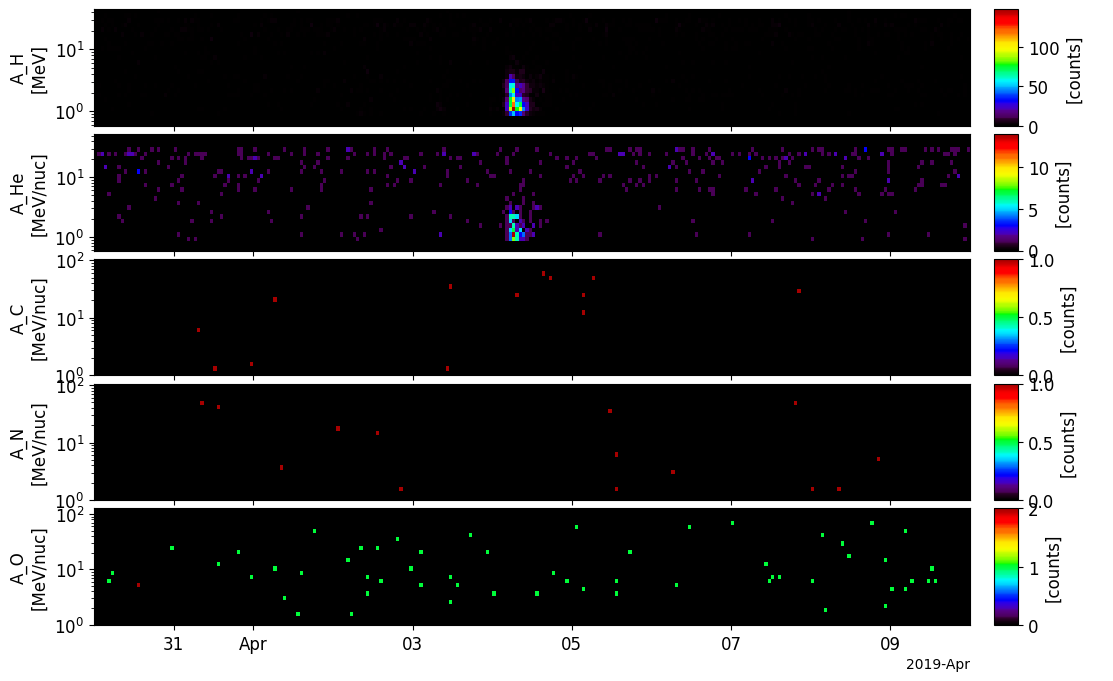

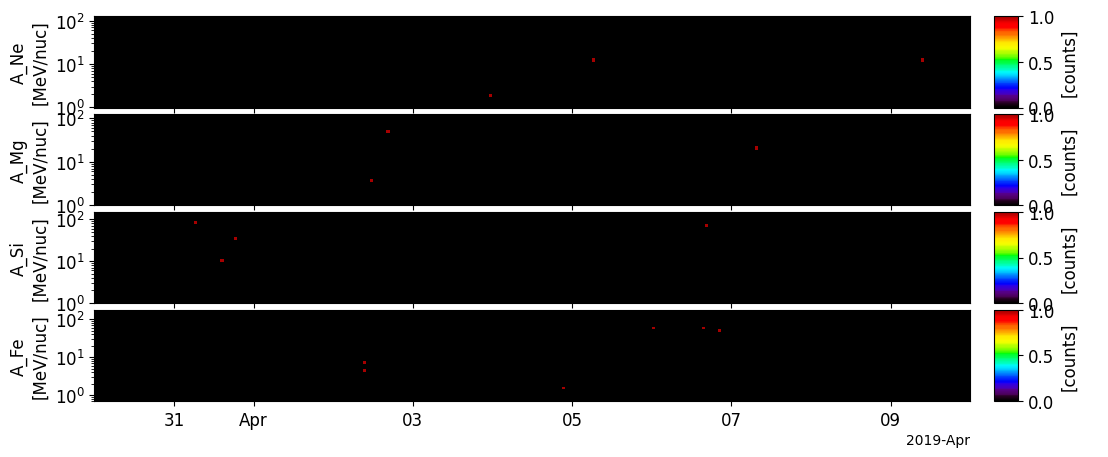

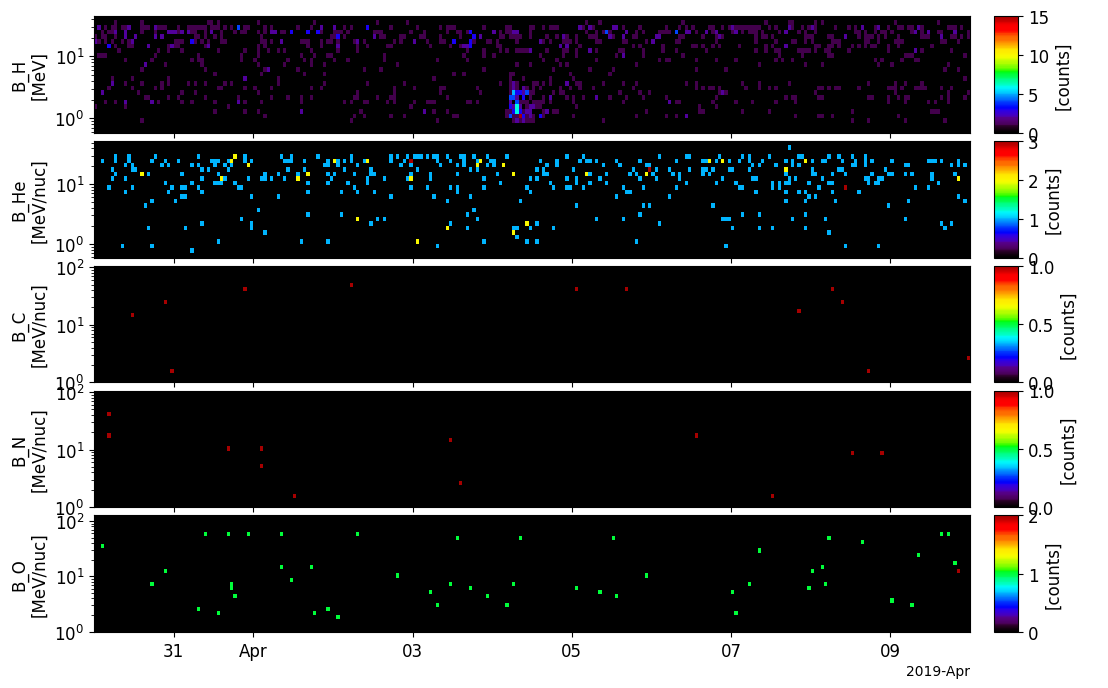

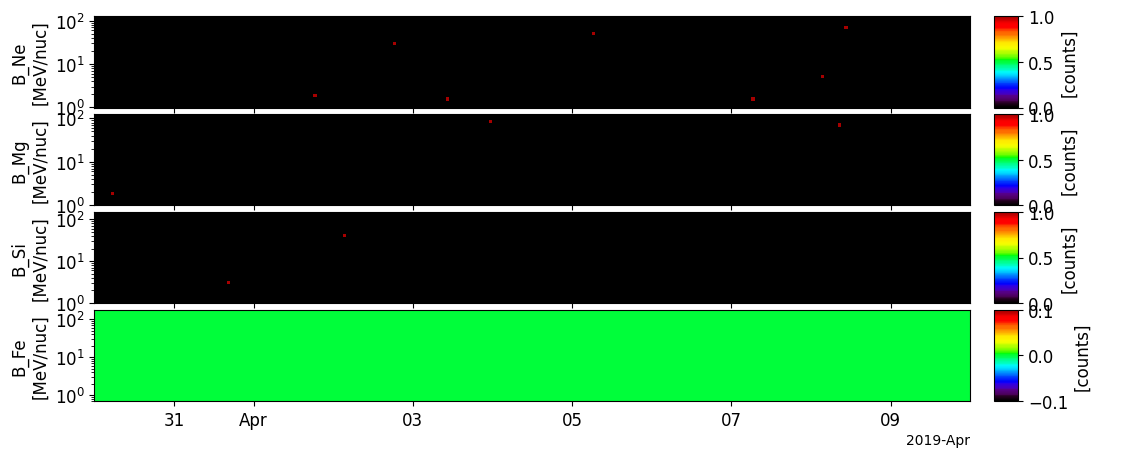

In [42]:
tplot(['psp_epihi_A_H', 'psp_epihi_A_He', 'psp_epihi_A_C', 'psp_epihi_A_N', 'psp_epihi_A_O'])
tplot(['psp_epihi_A_Ne', 'psp_epihi_A_Mg', 'psp_epihi_A_Si', 'psp_epihi_A_Fe'])
tplot(['psp_epihi_B_H', 'psp_epihi_B_He', 'psp_epihi_B_C', 'psp_epihi_B_N', 'psp_epihi_B_O'])
tplot(['psp_epihi_B_Ne', 'psp_epihi_B_Mg', 'psp_epihi_B_Si', 'psp_epihi_B_Fe'])

In [3]:
import pyspedas
from pytplot import tplot
epi_vars = pyspedas.psp.epihi(trange=orbit_dates[1], datatype='let2_rates1h', level='l2', time_clip=False)
print(epi_vars)

06-Aug-23 22:36:26: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/psp/isois/epihi/l2/let2_rates1h/2019/
06-Aug-23 22:36:27: File is current: psp_data/isois/epihi/l2/let2_rates1h/2019/psp_isois-epihi_l2-let2-rates3600_20190330_v16.cdf
06-Aug-23 22:36:27: File is current: psp_data/isois/epihi/l2/let2_rates1h/2019/psp_isois-epihi_l2-let2-rates3600_20190331_v16.cdf
06-Aug-23 22:36:27: File is current: psp_data/isois/epihi/l2/let2_rates1h/2019/psp_isois-epihi_l2-let2-rates3600_20190401_v16.cdf
06-Aug-23 22:36:27: File is current: psp_data/isois/epihi/l2/let2_rates1h/2019/psp_isois-epihi_l2-let2-rates3600_20190402_v16.cdf
06-Aug-23 22:36:27: File is current: psp_data/isois/epihi/l2/let2_rates1h/2019/psp_isois-epihi_l2-let2-rates3600_20190403_v16.cdf
06-Aug-23 22:36:27: File is current: psp_data/isois/epihi/l2/let2_rates1h/2019/psp_isois-epihi_l2-let2-rates3600_20190404_v16.cdf
06-Aug-23 22:36:27: File is current: psp_data/isois/epihi/l2/let2_rates1h/2019/psp_isois-epihi_l2-le

['psp_epihi_R1C_He_BIN', 'psp_epihi_R1C_Ne_BIN', 'psp_epihi_R2C_He_BIN', 'psp_epihi_R2C_Ne_BIN', 'psp_epihi_R3C_He_BIN', 'psp_epihi_R3C_Ne_BIN', 'psp_epihi_R45C_He_BIN', 'psp_epihi_R45C_Ne_BIN', 'psp_epihi_C_Al', 'psp_epihi_C_Ar', 'psp_epihi_C_C', 'psp_epihi_C_Ca', 'psp_epihi_C_Cr', 'psp_epihi_C_Fe', 'psp_epihi_C_H', 'psp_epihi_C_He', 'psp_epihi_C_Mg', 'psp_epihi_C_N', 'psp_epihi_C_Na', 'psp_epihi_C_Ne', 'psp_epihi_C_Ni', 'psp_epihi_C_O', 'psp_epihi_C_S', 'psp_epihi_C_Si', 'psp_epihi_C_Electrons', 'psp_epihi_HCI_R', 'psp_epihi_HCI_Lat', 'psp_epihi_HCI_Lon', 'psp_epihi_HGC_R', 'psp_epihi_HGC_Lat', 'psp_epihi_HGC_Lon', 'psp_epihi_LET2_C_PA', 'psp_epihi_LET2_C_SA', 'psp_epihi_LET2_C_RTN', 'psp_epihi_LET2_C_HCI', 'psp_epihi_LET2_C_R1_SECT_PA', 'psp_epihi_LET2_C_R1_SECT_SA', 'psp_epihi_LET2_C_R25_SECT_PA', 'psp_epihi_LET2_C_R25_SECT_SA', 'psp_epihi_R1C_CNO_SECT_Rate', 'psp_epihi_R1C_FeGroup_SECT_Rate', 'psp_epihi_R1C_H_SECT_Rate', 'psp_epihi_R1C_H_SECT_Flux', 'psp_epihi_R1C_He_SECT_Rate', '

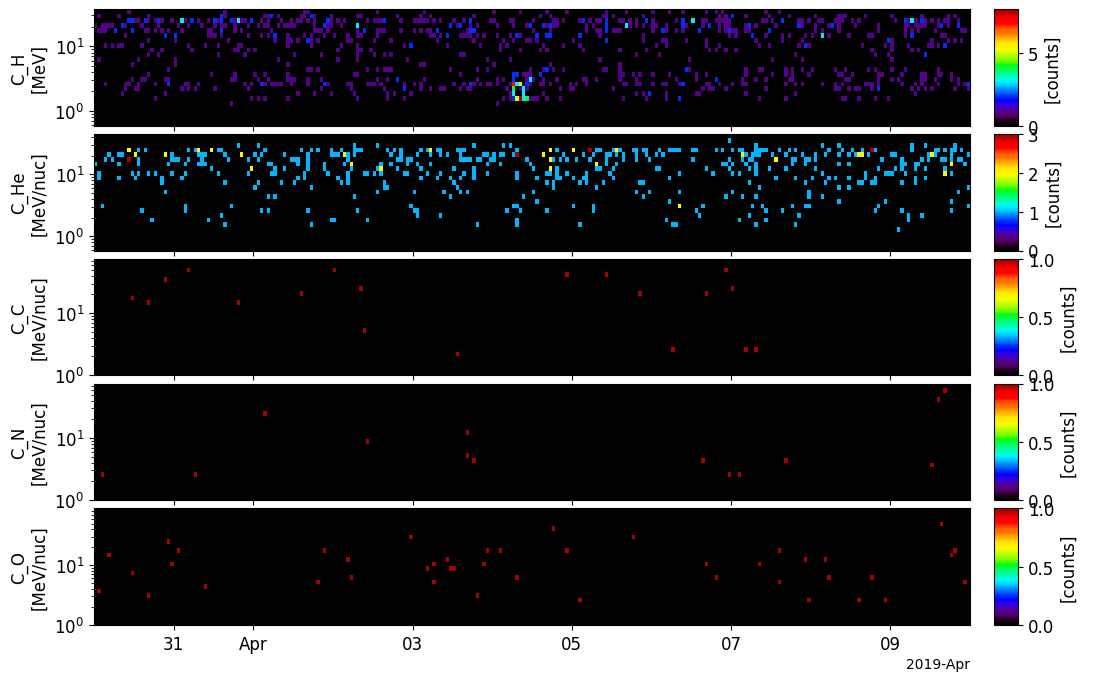

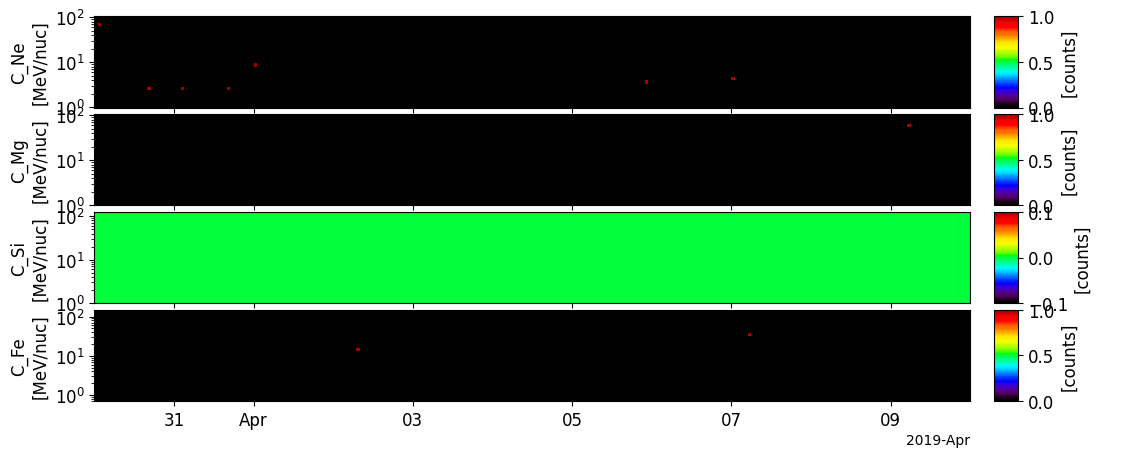

In [4]:
tplot(['psp_epihi_C_H', 'psp_epihi_C_He', 'psp_epihi_C_C', 'psp_epihi_C_N', 'psp_epihi_C_O'])
tplot(['psp_epihi_C_Ne', 'psp_epihi_C_Mg', 'psp_epihi_C_Si', 'psp_epihi_C_Fe'])

In [5]:
import pyspedas
from pytplot import tplot
epi_vars = pyspedas.psp.epihi(trange=orbit_dates[1], datatype='het_rates1h', level='l2', time_clip=False)
print(epi_vars)

06-Aug-23 22:37:42: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/psp/isois/epihi/l2/het_rates1h/2019/
06-Aug-23 22:37:42: File is current: psp_data/isois/epihi/l2/het_rates1h/2019/psp_isois-epihi_l2-het-rates3600_20190330_v16.cdf
06-Aug-23 22:37:42: File is current: psp_data/isois/epihi/l2/het_rates1h/2019/psp_isois-epihi_l2-het-rates3600_20190331_v16.cdf
06-Aug-23 22:37:42: File is current: psp_data/isois/epihi/l2/het_rates1h/2019/psp_isois-epihi_l2-het-rates3600_20190401_v16.cdf
06-Aug-23 22:37:42: File is current: psp_data/isois/epihi/l2/het_rates1h/2019/psp_isois-epihi_l2-het-rates3600_20190402_v16.cdf
06-Aug-23 22:37:43: File is current: psp_data/isois/epihi/l2/het_rates1h/2019/psp_isois-epihi_l2-het-rates3600_20190403_v16.cdf
06-Aug-23 22:37:43: File is current: psp_data/isois/epihi/l2/het_rates1h/2019/psp_isois-epihi_l2-het-rates3600_20190404_v16.cdf
06-Aug-23 22:37:43: File is current: psp_data/isois/epihi/l2/het_rates1h/2019/psp_isois-epihi_l2-het-rates3600_20

['psp_epihi_R1A_He_BIN', 'psp_epihi_R1A_Ne_BIN', 'psp_epihi_R1B_He_BIN', 'psp_epihi_R1B_Ne_BIN', 'psp_epihi_R2A_He_BIN', 'psp_epihi_R2A_Ne_BIN', 'psp_epihi_R2B_He_BIN', 'psp_epihi_R2B_Ne_BIN', 'psp_epihi_R3A_He_BIN', 'psp_epihi_R3A_Ne_BIN', 'psp_epihi_R3B_He_BIN', 'psp_epihi_R3B_Ne_BIN', 'psp_epihi_R4A_He_BIN', 'psp_epihi_R4A_Ne_BIN', 'psp_epihi_R4B_He_BIN', 'psp_epihi_R4B_Ne_BIN', 'psp_epihi_R5A_He_BIN', 'psp_epihi_R5A_Ne_BIN', 'psp_epihi_R5B_He_BIN', 'psp_epihi_R5B_Ne_BIN', 'psp_epihi_R6A_He_BIN', 'psp_epihi_R6A_Ne_BIN', 'psp_epihi_R6B_He_BIN', 'psp_epihi_R6B_Ne_BIN', 'psp_epihi_R7A_He_BIN', 'psp_epihi_R7A_Ne_BIN', 'psp_epihi_R7B_He_BIN', 'psp_epihi_R7B_Ne_BIN', 'psp_epihi_A_Al', 'psp_epihi_A_Ar', 'psp_epihi_A_C', 'psp_epihi_A_Ca', 'psp_epihi_A_Cr', 'psp_epihi_A_Electrons', 'psp_epihi_A_Fe', 'psp_epihi_A_H', 'psp_epihi_A_He', 'psp_epihi_A_Mg', 'psp_epihi_A_N', 'psp_epihi_A_Na', 'psp_epihi_A_Ne', 'psp_epihi_A_Ni', 'psp_epihi_A_O', 'psp_epihi_A_S', 'psp_epihi_A_Si', 'psp_epihi_B_Al', '

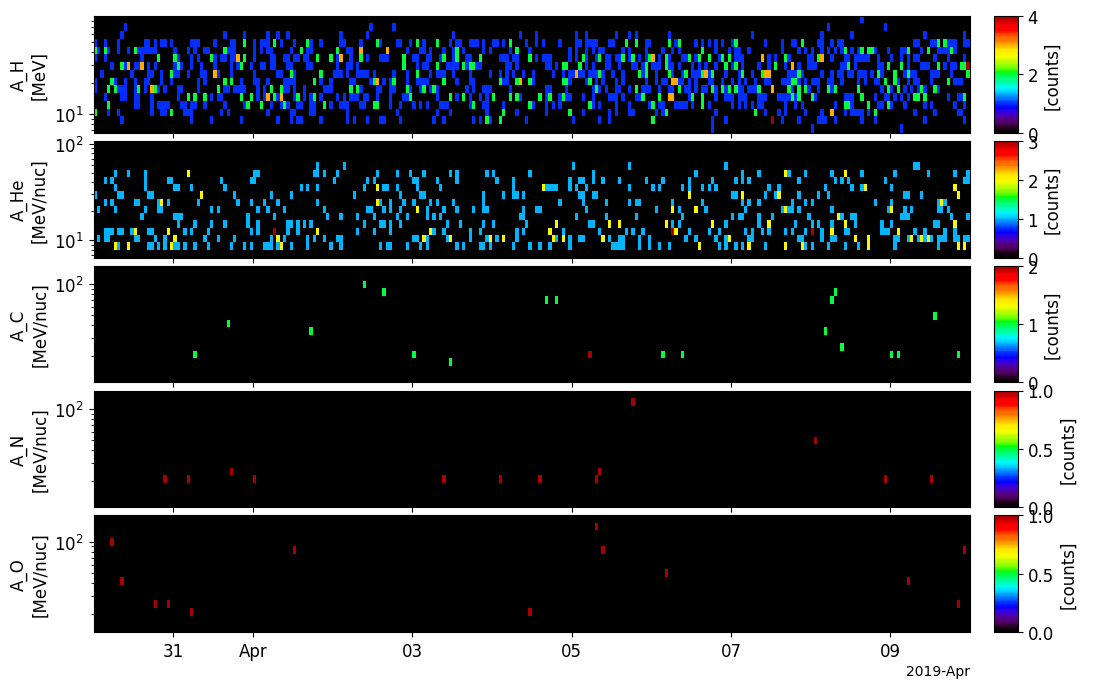

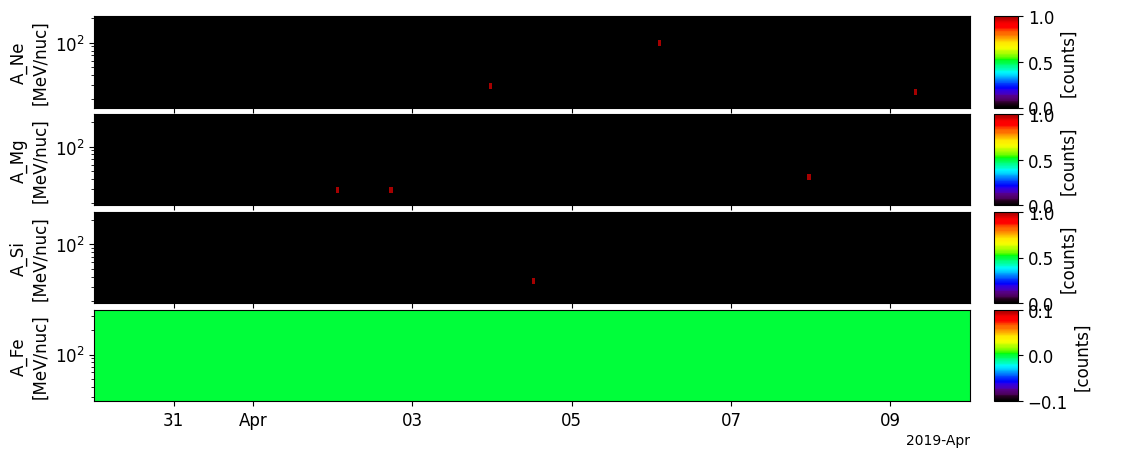

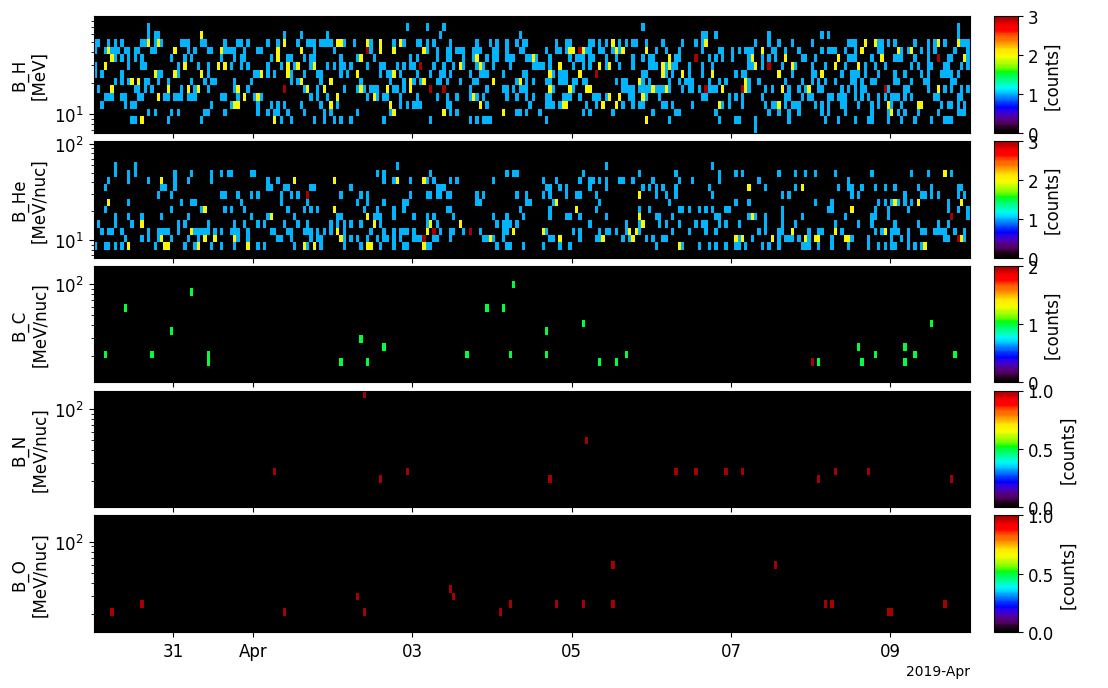

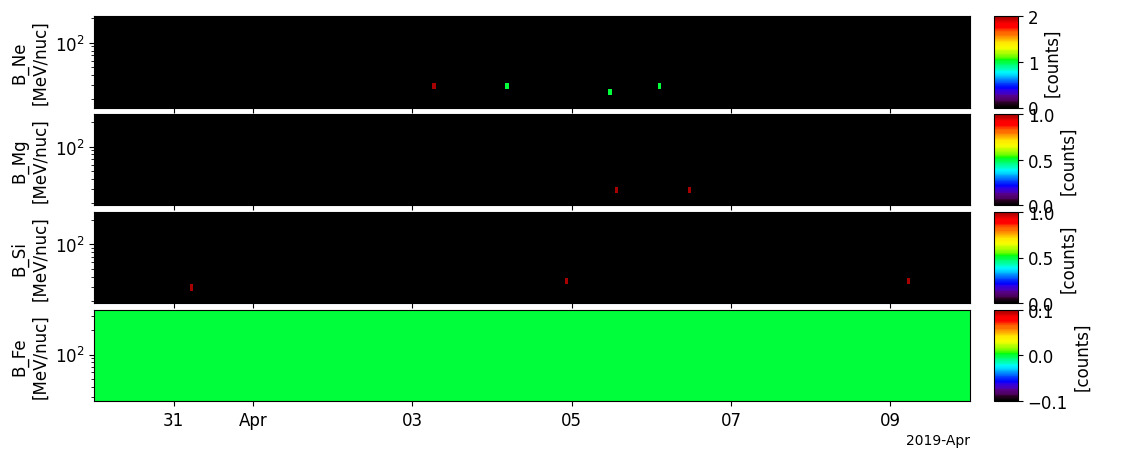

In [6]:
tplot(['psp_epihi_A_H', 'psp_epihi_A_He', 'psp_epihi_A_C', 'psp_epihi_A_N', 'psp_epihi_A_O'])
tplot(['psp_epihi_A_Ne', 'psp_epihi_A_Mg', 'psp_epihi_A_Si', 'psp_epihi_A_Fe'])
tplot(['psp_epihi_B_H', 'psp_epihi_B_He', 'psp_epihi_B_C', 'psp_epihi_B_N', 'psp_epihi_B_O'])
tplot(['psp_epihi_B_Ne', 'psp_epihi_B_Mg', 'psp_epihi_B_Si', 'psp_epihi_B_Fe'])

06-Aug-23 22:39:16: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/psp/isois/merged/l2/summary/2019/
06-Aug-23 22:39:17: Downloading https://spdf.gsfc.nasa.gov/pub/data/psp/isois/merged/l2/summary/2019/psp_isois_l2-summary_20190330_v16.cdf to psp_data/isois/merged/l2/summary/2019/psp_isois_l2-summary_20190330_v16.cdf
06-Aug-23 22:39:17: Download complete: psp_data/isois/merged/l2/summary/2019/psp_isois_l2-summary_20190330_v16.cdf
06-Aug-23 22:39:17: Downloading https://spdf.gsfc.nasa.gov/pub/data/psp/isois/merged/l2/summary/2019/psp_isois_l2-summary_20190331_v16.cdf to psp_data/isois/merged/l2/summary/2019/psp_isois_l2-summary_20190331_v16.cdf
06-Aug-23 22:39:17: Download complete: psp_data/isois/merged/l2/summary/2019/psp_isois_l2-summary_20190331_v16.cdf
06-Aug-23 22:39:17: Downloading https://spdf.gsfc.nasa.gov/pub/data/psp/isois/merged/l2/summary/2019/psp_isois_l2-summary_20190401_v16.cdf to psp_data/isois/merged/l2/summary/2019/psp_isois_l2-summary_20190401_v16.cdf


['psp_isois_HET_A_H_Rate_TS', 'psp_isois_HET_A_Electrons_Rate_TS', 'psp_isois_A_H_Rate_TS', 'psp_isois_A_Heavy_Rate_TS', 'psp_isois_H_CountRate_ChanP_SP', 'psp_isois_Electron_CountRate_ChanE']


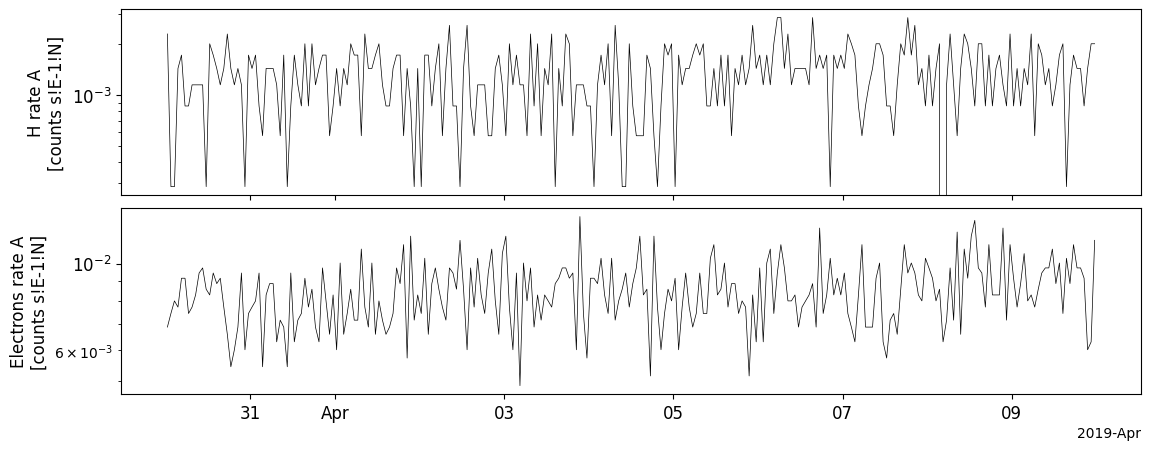

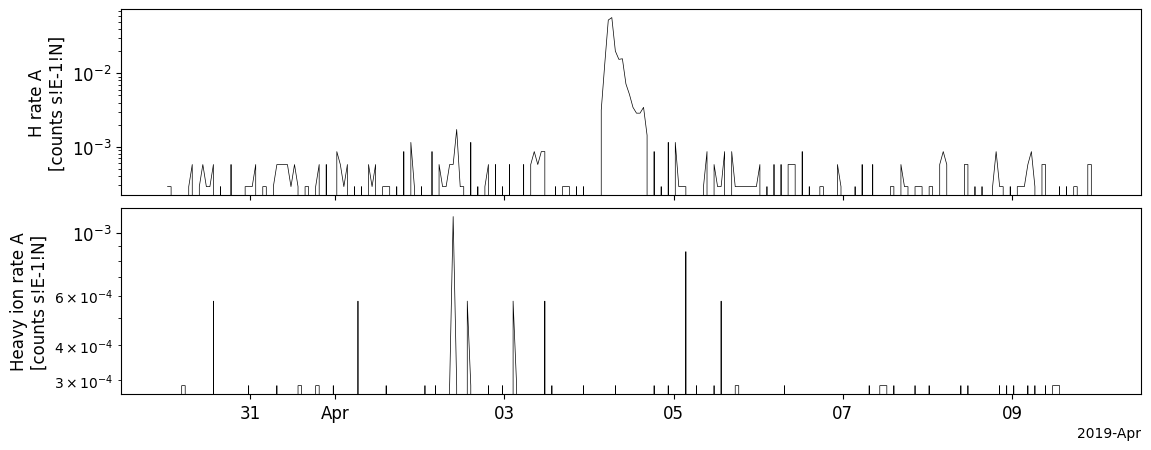

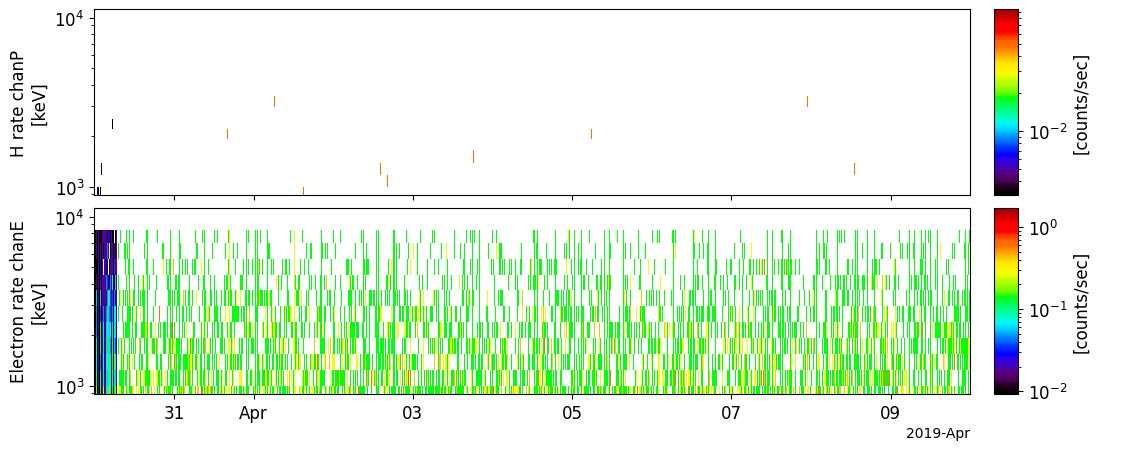

In [7]:
import pyspedas
from pytplot import tplot
epi_vars = pyspedas.psp.epi(trange=orbit_dates[1], datatype='summary', level='l2', time_clip=False)
print(epi_vars)
tplot(['psp_isois_HET_A_H_Rate_TS', 'psp_isois_HET_A_Electrons_Rate_TS'])
tplot(['psp_isois_A_H_Rate_TS', 'psp_isois_A_Heavy_Rate_TS'])
tplot(['psp_isois_H_CountRate_ChanP_SP', 'psp_isois_Electron_CountRate_ChanE'])